In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
sys.path.append("..")
from util import d2lzh_pytorch as d2l
print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)

1.1.0


In [2]:
train_data = pd.read_csv('Dataset\\house-prices-advanced-regression-techniques\\train.csv')
test_data = pd.read_csv('Dataset\\house-prices-advanced-regression-techniques\\test.csv')
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [3]:
print(train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]])
print(train_data.head())

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub

In [4]:
# 把train和test的79个特征拼接起来
all_features = pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))
print(all_features.shape)

(2919, 79)


In [5]:
# 数值类型的特征标准化一下
numeric_features = all_features.dtypes[all_features.dtypes!='object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x:(x-x.mean())/(x.std()))
all_features = all_features.fillna(0)

In [6]:
# 离散型的数值向量化 onehot
all_features = pd.get_dummies(all_features,dummy_na=True) # 哑变量编码
all_features.shape

(2919, 354)

In [7]:
# 转成tensor
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values,dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values,dtype=torch.float)
print(train_labels.shape)
train_labels = train_labels.view(-1,1)
print(train_labels.shape)

torch.Size([1460])
torch.Size([1460, 1])


- 下面用一些简单模型，比如回归

In [8]:
loss = nn.MSELoss()

def get_net(feature_num):
    net = nn.Linear(feature_num,1)
    for param in net.parameters():
        nn.init.normal_(param,mean=0,std=0.01)
    return net

def log_rmse(net,features,labels):
    with torch.no_grad():
        # 因为小于1的对数是负值，所以做个截断
        clipped_preds = torch.max(net(features),torch.tensor(1.0))
        rmse = torch.sqrt(2*loss(clipped_preds.log(),labels.log()).mean())
        return rmse.item()

def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    # 制作dataloader
    dataset = torch.utils.data.TensorDataset(train_features,train_labels)
    train_iter = torch.utils.data.DataLoader(dataset,batch_size,shuffle=True)
    optimizer = torch.optim.Adam(params=net.parameters(),lr=learning_rate,weight_decay=weight_decay)
    net = net.float()# 第一次见这种操作
    for epoch in range(num_epochs):
        for X,y in train_iter:
            l = loss(net(X.float()),y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse', range(1, num_epochs + 1), valid_ls, ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

fold 0, train rmse 0.241865, valid rmse 0.221914
fold 1, train rmse 0.229250, valid rmse 0.269052
fold 2, train rmse 0.232271, valid rmse 0.237874
fold 3, train rmse 0.238523, valid rmse 0.218515
fold 4, train rmse 0.230855, valid rmse 0.258195
5-fold validation: avg train rmse 0.234553, avg valid rmse 0.241110


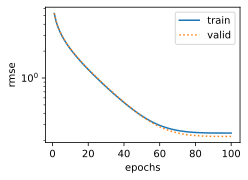

In [9]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))

train rmse 0.230148


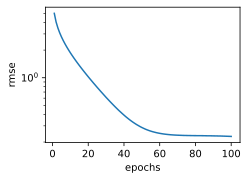

In [10]:
def train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size):
    net = get_net(train_features.shape[1])
    train_ls,_ = train(net,train_features,train_labels,None,None,num_epochs,lr,weight_decay,batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs','rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1) submission.to_csv('./submission.csv', index=False)
    
train_and_pred(train_features, test_features, train_labels,test_data, num_epochs, lr, weight_decay, batch_size)